In [1]:
#import libraries keys and setup data direcotry
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
from datetime import date
import os
import sys
import random
from scipy.stats import linregress
from scipy.stats import normaltest
from citipy import citipy
import json
import gmaps
from math import nan


#Include api directory in path
sys.path.append("api")

# Import API key
from config import g_key
from config import np_key

#National Park Endpoints
np_endpoint_parks = "https://developer.nps.gov/api/v1/parks?"

output_graphs = "data/graphs/"


#DataFrame Descriptions
#attendance_master_detail - National Visit - Location code, activity count - One record per park per year.
#Final_Budget_df - Clean National Park Budget Data - One record per park per year. 
#Max_Year_df - Max Year Visits With location codes -  One record per park. Representing visits from most recent year.
#Budget_Attendance_final_df - Merge of visit, budget (including adjusted for cpi), location codes,state, activity count. One record per year per park.
#National Park activities - One record per activity per national park.  (Just in case, but most likely won't use.)



In [2]:
# Import the park atendence csv file
attendance_df = pd.read_csv("data/Visists 1979-2019 v2.csv")
attendance_df

,Park Name,Year,Visits
0,Abraham Lincoln Birthplace NHP,2019,238226
1,Abraham Lincoln Birthplace NHP,1979,271231
2,Abraham Lincoln Birthplace NHP,1980,239074
3,Abraham Lincoln Birthplace NHP,1981,252245
4,Abraham Lincoln Birthplace NHP,1982,318707
...,...,...,...
13738,Zion NP,2014,3189696
13739,Zion NP,2015,3648846
13740,Zion NP,2016,4295127
13741,Zion NP,2017,4504812


In [3]:
# Filter through our attendence DataFrame to fibd only our National Parks
national_park_df = attendance_df[attendance_df["Park Name"].str.contains("NP")]
national_park_df

,Park Name,Year,Visits
41,Acadia NP,2019,3437286
42,Acadia NP,1979,2787366
43,Acadia NP,1980,2779666
44,Acadia NP,1981,2997972
45,Acadia NP,1982,3572114
...,...,...,...
13738,Zion NP,2014,3189696
13739,Zion NP,2015,3648846
13740,Zion NP,2016,4295127
13741,Zion NP,2017,4504812


In [4]:
# Import the national park budgets data csv file
# Final_NP_Budgets_df = pd.read_csv("data/National_Parks_Budgets.csv")
Final_NP_Budgets_df = pd.read_csv("data/National_Parks_Budget.csv")
del Final_NP_Budgets_df['Unnamed: 0']
Final_NP_Budgets_df
# National_Parks_Budget

,Park Name,Budget Request(dollars in thousands),Year
0,Acadia NP,4706,2002
1,Arches NP,1020,2002
2,Badlands NP,3072,2002
3,Big Bend NP,4735,2002
4,Biscayne NP,3480,2002
...,...,...,...
1224,Wrangell-Saint Elias NP&Pres,5634,2020
1225,Yellowstone NP,34410,2020
1226,Yosemite NP,30032,2020
1227,Yukon-Charley Rivers NPres,1768,2020


In [5]:
# Import the consumer price index file to help us adjust budgets for inflation
cpi_df = pd.read_excel("data/cpi_table.xlsx")
cpi_df.head

<bound method NDFrame.head of     YEAR      CPI
0   2020  258.811
1   2019  255.657
2   2018  251.107
3   2017  245.120
4   2016  240.008
5   2015  237.017
6   2014  236.736
7   2013  232.957
8   2012  229.594
9   2011  224.939
10  2010  218.056
11  2009  214.537
12  2008  215.303
13  2007  207.342
14  2006  201.600
15  2005  195.300
16  2004  188.900
17  2003  183.960
18  2002  179.880
19  2001  177.100
20  2000  172.200
21  1999  166.600
22  1998  163.000
23  1997  160.500
24  1996  156.900
25  1995  152.400
26  1994  148.200
27  1993  144.500
28  1992  140.300
29  1991  136.200
30  1990  130.700
31  1989  124.000
32  1988  118.300
33  1987  113.600
34  1986  109.600
35  1985  107.600
36  1984  103.900
37  1983   99.600
38  1982   96.500
39  1981   90.900
40  1980   82.400
41  1979   72.600
42  1978   65.200
43  1977   60.600
44  1976   56.900
45  1975   53.800
46  1974   49.300
47  1973   44.400
48  1972   41.800
49  1971   40.500
50  1970   38.800>

In [6]:
#The following function will return adjusted prior year abount based on CPI of current year and prior year.

def cpi_fnc ( current_year,prior_year, prior_amount ):
    
    ret_val = 0
    if type(prior_year) != 'int' or  type(current_year) != 'int':
        try:
            prior_year = int(prior_year)
            current_year = int(current_year)
        except:
            print(f"Type Error: Make sure to pass int values or strings that will convert to int")
        if len(cpi_df[cpi_df["YEAR"] == prior_year]) == 0:
                  print(f"Year {str(prior_year)} does not exist in CPI table")
        elif len(cpi_df[cpi_df["YEAR"] == current_year]) == 0:
                  print(f"Year {str(current_year)} does not exist in CPI table")
        else:
            v_curr_year_cpi = cpi_df[cpi_df["YEAR"] == current_year]["CPI"].values[0]
            v_prior_year_cpi = cpi_df[cpi_df["YEAR"] == prior_year]["CPI"].values[0]          
            adjusted_amount = prior_amount * float((v_curr_year_cpi/v_prior_year_cpi))
            ret_val = round(adjusted_amount,2)
    return ret_val

In [7]:
Final_NP_Budgets_df["AdjBudg(dollars in thousands)"] = 0

for index, row in Final_NP_Budgets_df.iterrows():
    Final_NP_Budgets_df.loc[index,"AdjBudg(dollars in thousands)"] = cpi_fnc ( 2020, row["Year"], row["Budget Request(dollars in thousands)"])


Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 do

In [8]:
#CPI Test Statement

x = cpi_fnc(2020,2002,1020)
print(str(x))


1467.57


In [9]:
Final_NP_Budgets_df.head()

,Park Name,Budget Request(dollars in thousands),Year,AdjBudg(dollars in thousands)
0,Acadia NP,4706,2002,6770.98
1,Arches NP,1020,2002,1467.57
2,Badlands NP,3072,2002,4419.99
3,Big Bend NP,4735,2002,6812.71
4,Biscayne NP,3480,2002,5007.02


In [10]:
us_census_df = pd.read_excel("data/US_Population_Table_MacroTrends.xlsx")
us_census_df

,Year,Population,AnnualPctChange
0,1950,158804395,0.00
1,1951,160872266,1.30
2,1952,163266028,1.49
3,1953,165910003,1.62
4,1954,168736387,1.70
...,...,...,...
66,2016,323015995,0.67
67,2017,325084756,0.64
68,2018,327096265,0.62
69,2019,329064917,0.60


In [11]:
#Geocode work.  Utilizing existing Attendance 
np_master_df =pd.read_csv("data/national_park_master.csv")
np_master_df.head()

,parkCode,fullName,lat,lon,Park Name
0,acad,Acadia National Park,44.409286,-68.247501,Acadia NP
1,arch,Arches National Park,38.722618,-109.586367,Arches NP
2,badl,Badlands National Park,43.685848,-102.482942,Badlands NP
3,bibe,Big Bend National Park,29.298178,-103.229790,Big Bend NP
4,bisc,Biscayne National Park,25.490587,-80.210239,Biscayne NP


In [12]:
#Connect to NP API parks endpoint to get park state and activities
parkCode_list = []
activities_list = []
np_master_df["State"] = " "
np_master_df["Activity Count"] = 0

for index, row in np_master_df.iterrows():
    params = { "api_key": np_key,
               "parkCode":row["parkCode"]
             }
    response = requests.get(np_endpoint_parks,params).json()
    if len(response["data"][0]["addresses"]) > 0:
        np_master_df.loc[index,"State"] = response["data"][0]["addresses"][0]["stateCode"]
    np_master_df.loc[index,"Activity Count"] = len(response["data"][0]["activities"])
    for activity in response["data"][0]["activities"]:
        parkCode_list.append(row["parkCode"])
        activities_list.append(activity["name"])

In [13]:
#Build NP Activities List
np_activities = pd.DataFrame ({"parkCode":parkCode_list, "Activity":activities_list})

#Build Park Activies DataFrame
np_activities_df = pd.DataFrame ({"parkCode":parkCode_list, "Activity":activities_list})
np_activities_df["Cnt"] = 1

np_activities

,parkCode,Activity
0,acad,Arts and Culture
1,acad,Cultural Demonstrations
2,acad,Astronomy
3,acad,Stargazing
4,acad,Biking
...,...,...
1540,zion,Birdwatching
1541,zion,Park Film
1542,zion,Museum Exhibits
1543,zion,Shopping


In [14]:
#creating data frame joining master table and detail visists
attendance_master_stg = pd.merge(national_park_df, np_master_df, how="inner", on=["Park Name"])
attendance_master_detail = pd.merge(attendance_master_stg,Final_NP_Budgets_df, how="inner", on=["Park Name","Year"])

attendance_master_detail.head(-10)

,Park Name,Year,Visits,parkCode,fullName,lat,lon,State,Activity Count,Budget Request(dollars in thousands),AdjBudg(dollars in thousands)
0,Acadia NP,2019,3437286,acad,Acadia National Park,44.409286,-68.247501,ME,46,7312,7402.21
1,Acadia NP,2002,2558572,acad,Acadia National Park,44.409286,-68.247501,ME,46,4706,6770.98
2,Acadia NP,2003,2431062,acad,Acadia National Park,44.409286,-68.247501,ME,46,5686,7999.56
3,Acadia NP,2004,2207847,acad,Acadia National Park,44.409286,-68.247501,ME,46,6415,8789.16
4,Acadia NP,2005,2051484,acad,Acadia National Park,44.409286,-68.247501,ME,46,6277,8318.26
...,...,...,...,...,...,...,...,...,...,...,...
777,Zion NP,2004,2677342,zion,Zion National Park,37.298393,-113.026514,UT,22,6128,8395.94
778,Zion NP,2005,2586665,zion,Zion National Park,37.298393,-113.026514,UT,22,6008,7961.78
779,Zion NP,2006,2567350,zion,Zion National Park,37.298393,-113.026514,UT,22,7272,9335.68
780,Zion NP,2007,2657281,zion,Zion National Park,37.298393,-113.026514,UT,22,6585,8219.61


In [15]:
# Use the groupby and then a max function to find the most recent year for our data
most_recent_year = attendance_master_detail.groupby(['Park Name'])['Year'].max()
most_recent_year_reset = most_recent_year.reset_index()
most_recent_year_reset.head()

,Park Name,Year
0,Acadia NP,2019
1,Arches NP,2019
2,Badlands NP,2019
3,Big Bend NP,2019
4,Biscayne NP,2019


In [16]:
#creating a new data frame for our most recent year (2019) by bringing in the budget, location, visits, and activities.

# now that we have our data frame for 2019 and location we will merge them by park name
Max_Year_df = pd.merge(most_recent_year_reset, np_master_df, how="inner", on=["Park Name"])
# now that we have our data frame for 2019 and visits we will merge them by park name
year_2019_df = pd.merge(Max_Year_df,national_park_df,how="inner", on=["Park Name","Year"])
year_2019_df.head()

,Park Name,Year,parkCode,fullName,lat,lon,State,Activity Count,Visits
0,Acadia NP,2019,acad,Acadia National Park,44.409286,-68.247501,ME,46,3437286
1,Arches NP,2019,arch,Arches National Park,38.722618,-109.586367,UT,20,1659702
2,Badlands NP,2019,badl,Badlands National Park,43.685848,-102.482942,SD,21,970998
3,Big Bend NP,2019,bibe,Big Bend National Park,29.298178,-103.229790,TX,19,463832
4,Biscayne NP,2019,bisc,Biscayne National Park,25.490587,-80.210239,FL,13,708522


In [17]:
# create our final data frame by bringing in the budget, location, visits, and activities.

# now that we have our budget data frame and visits we will merge them by park name
budget_attendance_merged = pd.merge(Final_NP_Budgets_df, national_park_df, how="inner", on=["Park Name","Year"])
# now that we have our budget data frame and locaiton we will merge them by park name
budget_attendance_final_df = pd.merge(budget_attendance_merged,np_master_df,how="inner", on=["Park Name"])
# budget_attendance_final_df

In [18]:
# We will now create a table for the top 10 most visited parks in 2019
year_2019_df[["Park Name","Year","Visits"]].sort_values(by=["Visits"],ascending=False).head(10)

,Park Name,Year,Visits
21,Great Smoky Mountains NP,2019,12547743
18,Grand Canyon NP,2019,5974411
36,Rocky Mountain NP,2019,4670053
45,Zion NP,2019,4488268
44,Yosemite NP,2019,4422861
43,Yellowstone NP,2019,4020288
0,Acadia NP,2019,3437286
19,Grand Teton NP,2019,3405614
33,Olympic NP,2019,3245806
17,Glacier NP,2019,3049839


In [19]:
# We will now create a table for the top 10 least visited parks in 2019
year_2019_df[["Park Name","Year","Visits"]].sort_values(by=["Visits"]).head(10)

,Park Name,Year,Visits
26,Isle Royale NP,2019,26410
15,Dry Tortugas NP,2019,79200
20,Great Basin NP,2019,131802
40,Virgin Islands NP,2019,133398
11,Congaree NP,2019,159445
35,Pinnacles NP,2019,177224
22,Guadalupe Mountains NP,2019,188833
41,Voyageurs NP,2019,232974
28,Kenai Fjords NP,2019,356601
10,Channel Islands NP,2019,409630


In [20]:
#Addded 2/7/2021 By Mike  Summary Parks, Visits By Year  Data check
attendance_master_summ_df = national_park_df.groupby(by=["Year"]).agg({"Park Name":"count",
                                                                          "Visits":"sum"}).reset_index()
attendance_master_summ_df.sort_values(by="Year").head()

,Year,Park Name,Visits
0,1979,56,53194116
1,1980,56,54540968
2,1981,57,57774669
3,1982,64,57794412
4,1983,64,58788866


In [21]:
year_2019_df
locations= year_2019_df[['lat', 'lon']].astype(float)
locations.head()

,lat,lon
0,44.409286,-68.247501
1,38.722618,-109.586367
2,43.685848,-102.482942
3,29.298178,-103.229790
4,25.490587,-80.210239


In [22]:
#Create a Heat Map all National Parks using only the data for 2019.
gmaps.configure(api_key=g_key)

# Store 'Lat' and 'Lng' into  locations 
locations= year_2019_df[['lat', 'lon']].astype(float)
# Convert Poverty Rate to float and store
# HINT: be sure to handle NaN values
#census_data_complete = census_data_complete.dropna()
visits_all = year_2019_df["Visits"].astype(float)
max_visits = year_2019_df["Visits"].max() 

# Create a Heatmap layer using visits as our weight
fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights=visits_all, 
                                 dissipating=False, max_intensity=max_visits,
                                 point_radius = 1)

fig.add_layer(heat_layer)

fig

Figure(layout=FigureLayout(height='420px'))

In [23]:
##Create a Heat Map all National Parks using only the data for 2019 operating costs. 
# Get the most recent year for our merged data
Budget_2019_df = attendance_master_detail.loc[attendance_master_detail['Year'] == 2019]

gmaps.configure(api_key=g_key)
# Store 'Lat' and 'Lng' into  locations 
locations= Budget_2019_df[['lat', 'lon']].astype(float)


all_budgets = Budget_2019_df["Budget Request(dollars in thousands)"].astype(float)
max_budget = Budget_2019_df["Budget Request(dollars in thousands)"].max()


# Create# Create a Heatmap layer using park budgets as our weight
fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights=all_budgets, 
                                 dissipating=False, max_intensity=max_budget,
                                 point_radius = 1)

fig.add_layer(heat_layer)

fig

Figure(layout=FigureLayout(height='420px'))

In [24]:
# create a message prompting our user to input a national park name and it will return the data chosen park
park = input('Choose Park: ')
new_df = attendance_master_detail.loc[attendance_master_detail['Park Name'] == park]
new_df

Choose Park: Zion NP


,Park Name,Year,Visits,parkCode,fullName,lat,lon,State,Activity Count,Budget Request(dollars in thousands),AdjBudg(dollars in thousands)
774,Zion NP,2019,4488268,zion,Zion National Park,37.298393,-113.026514,UT,22,6949,7034.73
775,Zion NP,2002,2592545,zion,Zion National Park,37.298393,-113.026514,UT,22,5963,8579.55
776,Zion NP,2003,2458792,zion,Zion National Park,37.298393,-113.026514,UT,22,6044,8503.23
777,Zion NP,2004,2677342,zion,Zion National Park,37.298393,-113.026514,UT,22,6128,8395.94
778,Zion NP,2005,2586665,zion,Zion National Park,37.298393,-113.026514,UT,22,6008,7961.78
779,Zion NP,2006,2567350,zion,Zion National Park,37.298393,-113.026514,UT,22,7272,9335.68
780,Zion NP,2007,2657281,zion,Zion National Park,37.298393,-113.026514,UT,22,6585,8219.61
781,Zion NP,2008,2690154,zion,Zion National Park,37.298393,-113.026514,UT,22,7272,8741.51
782,Zion NP,2009,2735402,zion,Zion National Park,37.298393,-113.026514,UT,22,7831,9447.08
783,Zion NP,2010,2665972,zion,Zion National Park,37.298393,-113.026514,UT,22,8307,9859.59


In [25]:
# Determine if there are any potential outliers in the average visits of National Parks
quartiles = attendance_master_detail['Visits'].quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile of visits is: {lowerq}")
print(f"The upper quartile of visits is: {upperq}")
print(f"The interquartile range of vistis is: {iqr}")
print(f"The the median of visits is: {quartiles[0.5]} ")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

outlier_occupancy = attendance_master_detail.loc[(attendance_master_detail['Visits'] < lower_bound) | (attendance_master_detail['Visits'] > upper_bound)]
outlier_occupancy

The lower quartile of visits is: 410914.75
The upper quartile of visits is: 1887751.75
The interquartile range of vistis is: 1476837.0
The the median of visits is: 796851.5 
Values below -1804340.75 could be outliers.
Values above 4103007.25 could be outliers.


,Park Name,Year,Visits,parkCode,fullName,lat,lon,State,Activity Count,Budget Request(dollars in thousands),AdjBudg(dollars in thousands)
320,Grand Canyon NP,2019,5974411,grca,Grand Canyon National Park,36.000117,-112.121516,AZ,33,19376,19615.04
322,Grand Canyon NP,2003,4124900,grca,Grand Canyon National Park,36.000117,-112.121516,AZ,33,19016,26753.37
323,Grand Canyon NP,2004,4326234,grca,Grand Canyon National Park,36.000117,-112.121516,AZ,33,19248,26371.59
324,Grand Canyon NP,2005,4401522,grca,Grand Canyon National Park,36.000117,-112.121516,AZ,33,18566,24603.61
325,Grand Canyon NP,2006,4279439,grca,Grand Canyon National Park,36.000117,-112.121516,AZ,33,21704,27863.26
326,Grand Canyon NP,2007,4413668,grca,Grand Canyon National Park,36.000117,-112.121516,AZ,33,20106,25096.96
327,Grand Canyon NP,2008,4425314,grca,Grand Canyon National Park,36.000117,-112.121516,AZ,33,21704,26089.90
328,Grand Canyon NP,2009,4348068,grca,Grand Canyon National Park,36.000117,-112.121516,AZ,33,21962,26494.30
329,Grand Canyon NP,2010,4388386,grca,Grand Canyon National Park,36.000117,-112.121516,AZ,33,23076,27388.94
330,Grand Canyon NP,2011,4298178,grca,Grand Canyon National Park,36.000117,-112.121516,AZ,33,23331,26844.25


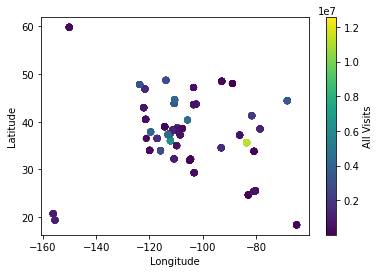

In [26]:
#latitude and longitude of the Attendance Master Detal based off Visits 
plt.scatter(attendance_master_detail['lon'],attendance_master_detail['lat'],c=attendance_master_detail['Visits'])
clb = plt.colorbar()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
clb.set_label("All Visits")
plt.show()

Text(0, 0.5, 'Visits')

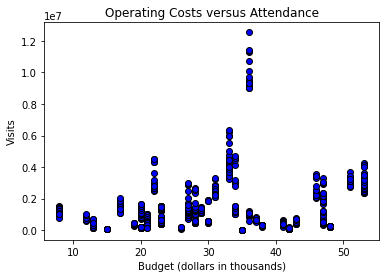

In [27]:
Analysis=budget_attendance_final_df.loc[:,["AdjBudg(dollars in thousands)","Visits","Activity Count", "Park Name", "Year"]]
Analysis
Activity_Count = Analysis["Activity Count"].values.tolist()
Budget = Analysis["Activity Count"].values.tolist()
Visits = Analysis["Visits"].values.tolist()
Year=Analysis["Year"].values.tolist()
# Budget, =plt.plot(Year,Budget, color = "green", label= "Visits")
# Attendance, =plt.plot(Year,Visits, color = "red", label= "Visits")
Operation =plt.scatter(Budget,Visits, color = "blue", label= "Visits",edgecolors="black")
# plt.xlim(2005,2022)
# plt.ylim(5,11000)
plt.title("Operating Costs versus Attendance")
plt.xlabel("Budget (dollars in thousands)")
plt.ylabel("Visits")

In [28]:
# We will bring the 2019 data for our National Parks 
Hist_data=Analysis.query('Year == "2019"')

# Now that we have our data for 2019 we will group by Park Name
group=Hist_data.groupby(["Park Name"]).head()

# We will find the national parks with the top 10 most activities
TopActivities=group.sort_values(by=["Activity Count"],ascending=False).head(10)

# We will find the national parks with the top 10 largest budgets
TopCost=group.sort_values(by=["AdjBudg(dollars in thousands)"],ascending=False).head(10)

# We will find the national parks with the top 10 most visits
TopVisit=group.sort_values(by=["Visits"],ascending=False).head(10)

# Create a list index to hold our new data sets
Histograms  = [TopVisit,TopCost,TopActivities]

# Now we will link our Histogams list using the concat function
Master_Top_10= pd.concat(Histograms)

# We will now clean the Master_Top_10 data frame by dropping our duplicate values
Clean_Master=Master_Top_10.sort_values(by=["Park Name"],ascending=False).drop_duplicates().head(10)

# Now with our cleaned data frame we will create the y variables for our bar plot
Finalact=Clean_Master["Activity Count"].values.tolist()
Finalbud=Clean_Master["AdjBudg(dollars in thousands)"].values.tolist()
Clean_Visit=Clean_Master['Visits'].values.tolist()

# Now with our cleaned data frame we will create the x variable for our bar plot
name=Clean_Master['Park Name'].values.tolist()

# We will now create a list index to hold the new data sets for our bar plot 
data= [[name,Clean_Visit,Finalbud,Finalact]]

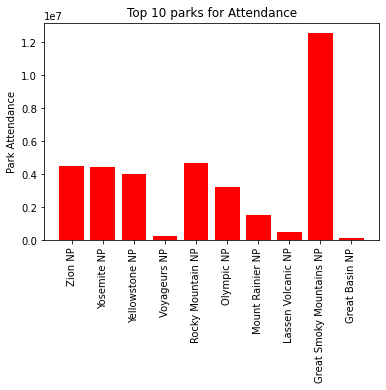

In [29]:
# Create a bar plot for the national parks with the top 10 most visits
plt.bar(name,Clean_Visit, color="r")
plt.xticks(rotation=90, horizontalalignment="center")
plt.title("Top 10 parks for Attendance")
plt.ylabel("Park Attendance")
plt.show()

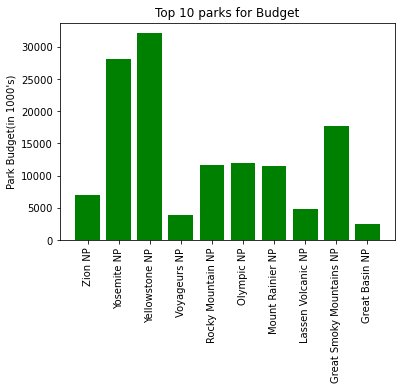

In [30]:
# Create a bar plot for the national parks with the top 10 largest budgets
plt.bar(name,Finalbud, color="g")
plt.xticks(rotation=90, horizontalalignment="center")
plt.title("Top 10 parks for Budget")
plt.ylabel("Park Budget(in 1000's)")
plt.show()

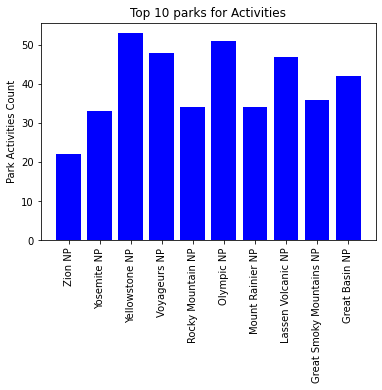

In [31]:
# Create a bar plot for the national parks with the top 10 most activities
plt.bar(name,Finalact, color="b")
plt.xticks(rotation=90, horizontalalignment="center")
plt.title("Top 10 parks for Activities")
plt.ylabel("Park Activities Count")
plt.show()
plt.show()

In [32]:
#Graph Park Name vs Budget over time
Budget2020=Final_NP_Budgets_df.query('Year == "2020"')
Ten_Most_Expensive2020=Budget2020[["Park Name", "AdjBudg(dollars in thousands)", "Year"]].sort_values(by=["AdjBudg(dollars in thousands)"],ascending=False).head(10)
Ten_Most_Expensive2020

,Park Name,AdjBudg(dollars in thousands),Year
1225,Yellowstone NP,34410.0,2020
1226,Yosemite NP,30032.0,2020
1186,Grand Canyon NP,20990.0,2020
1190,Great Smoky Mountains NP,18888.0,2020
1214,Sequoia NP & Kings Canyon NP,16621.0,2020
1181,Everglades NP,16393.0,2020
1179,Denali NP&Pres,14240.0,2020
1185,Glacier NP,13453.0,2020
1208,Olympic NP,12776.0,2020
1212,Rocky Mountain NP,12436.0,2020


In [33]:
#Graph Park Name vs Budget over time
Budget2021=Final_NP_Budgets_df.query('Year == "2021"')
Ten_Most_Expensive2021=Budget2021[["Park Name", "Budget Request(dollars in thousands)", "Year"]].sort_values(by=["Budget Request(dollars in thousands)"],ascending=False).head(10)
Ten_Most_Expensive2021

,Park Name,Budget Request(dollars in thousands),Year
965,Yellowstone NP,34585,2021
966,Yosemite NP,28647,2021
925,Grand Canyon NP,21223,2021
929,Great Smoky Mountains NP,19097,2021
920,Everglades NP,16433,2021
953,Sequoia NP & Kings Canyon NP,16229,2021
918,Denali NP&Pres,14263,2021
924,Glacier NP,13870,2021
951,Rocky Mountain NP,12635,2021
947,Olympic NP,12571,2021


No handles with labels found to put in legend.


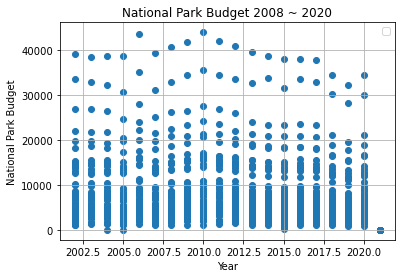

In [61]:
# We will create a scatter plot showing the national park budget, adjusted for inflation, from 2008-2020
Scatter_df=Final_NP_Budgets_df.loc[:,["Park Name", "AdjBudg(dollars in thousands)", "Year"]]
Park_Name=Scatter_df["Park Name"]
Adjusted_Budget=Scatter_df["AdjBudg(dollars in thousands)"]
Year=Scatter_df["Year"]
plt.scatter(Year, Adjusted_Budget)
plt.grid()
plt.title("National Park Budget 2008 ~ 2020")
plt.xlabel("Year")
plt.ylabel("National Park Budget")
plt.legend()
plt.show()

,Park Name,Budget Request(dollars in thousands),Year,AdjBudg(dollars in thousands)


In [35]:
budget_attendance_final_df

,Park Name,Budget Request(dollars in thousands),Year,AdjBudg(dollars in thousands),Visits,parkCode,fullName,lat,lon,State,Activity Count
0,Acadia NP,4706,2002,6770.98,2558572,acad,Acadia National Park,44.409286,-68.247501,ME,46
1,Acadia NP,5686,2003,7999.56,2431062,acad,Acadia National Park,44.409286,-68.247501,ME,46
2,Acadia NP,6415,2004,8789.16,2207847,acad,Acadia National Park,44.409286,-68.247501,ME,46
3,Acadia NP,6277,2005,8318.26,2051484,acad,Acadia National Park,44.409286,-68.247501,ME,46
4,Acadia NP,8130,2016,8766.93,3303393,acad,Acadia National Park,44.409286,-68.247501,ME,46
...,...,...,...,...,...,...,...,...,...,...,...
787,Congaree NP,1901,2017,2007.18,159595,cong,Congaree National Park,33.791875,-80.748678,SC,26
788,Congaree NP,1791,2018,1845.95,145929,cong,Congaree National Park,33.791875,-80.748678,SC,26
789,Congaree NP,1703,2019,1724.01,159445,cong,Congaree National Park,33.791875,-80.748678,SC,26
790,Pinnacles NP,3479,2014,3803.41,196635,pinn,Pinnacles National Park,36.490292,-121.181361,CA,26


In [36]:
#Productivity is measured as Visits/Per Dollars spent in thousands
#Productivity at park/year grain
Productivity_det_df = budget_attendance_final_df
Productivity_det_df["Prod (Visits Per Thousand Dollars)"] = round(Productivity_det_df["Visits"] / Productivity_det_df["AdjBudg(dollars in thousands)"],2)

#Build Productivity for all parks 
Productivity_summ_groupby = budget_attendance_final_df.groupby(by=["Year"])

Productivity_summ_df  = Productivity_summ_groupby["Visits","AdjBudg(dollars in thousands)"].sum().reset_index()
Productivity_summ_df["Prod (Visits Per Thousand Dollars)"] = round(Productivity_summ_df["Visits"] / Productivity_summ_df["AdjBudg(dollars in thousands)"],2)



<ipython-input-36-0bf9f1ba8e82>:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Productivity_summ_df  = Productivity_summ_groupby["Visits","AdjBudg(dollars in thousands)"].sum().reset_index()


In [37]:
Productivity_summ_df

,Year,Visits,AdjBudg(dollars in thousands),Prod (Visits Per Thousand Dollars)
0,2002,61782862,403869.17,152.98
1,2003,60655185,400851.78,151.32
2,2004,60546764,399127.93,151.70
3,2005,57477722,372327.37,154.37
4,2006,54486019,435292.90,125.17
5,2007,56064813,380174.14,147.47
6,2008,55259586,407588.60,135.58
7,2009,56868614,424297.18,134.03
8,2010,58361419,439614.08,132.76
9,2011,59371720,439833.37,134.99


<BarContainer object of 18 artists>

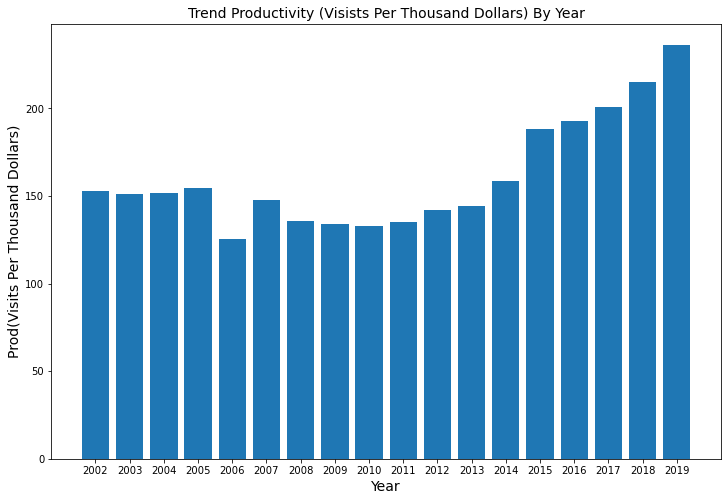

In [38]:
# We will create a bar plot showing the trend of budget productivity since 2002
plt.figure(figsize=(12,8))
plt.xticks(Productivity_summ_df["Year"])
plt.ylabel("Prod(Visits Per Thousand Dollars)",fontsize=14)
plt.xlabel("Year",fontsize=14)
plt.title("Trend Productivity (Visists Per Thousand Dollars) By Year",fontsize=14)
plt.bar(Productivity_summ_df["Year"], Productivity_summ_df["Prod (Visits Per Thousand Dollars)"],width=.8)

<ipython-input-39-b7c55ad7d66e>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig.figure(figsize=(11,6))
<ipython-input-39-b7c55ad7d66e>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig.figure(figsize=(11,6))
<ipython-input-39-b7c55ad7d66e>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig.figure(figsize=(11,6)

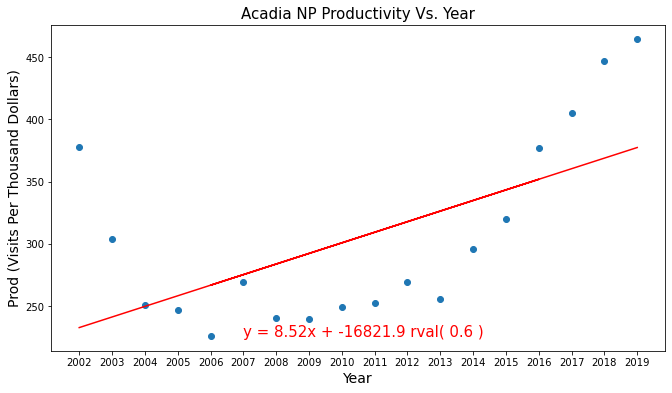

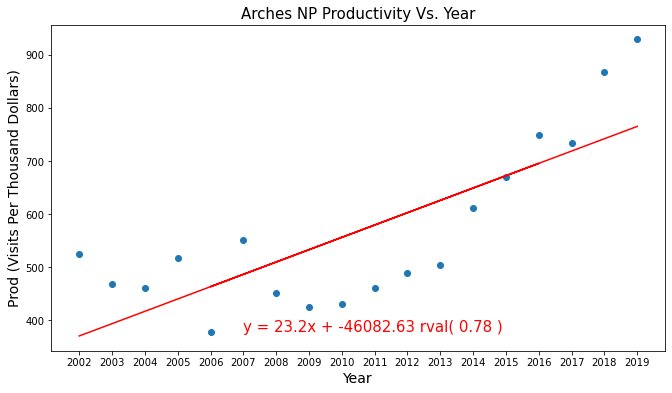

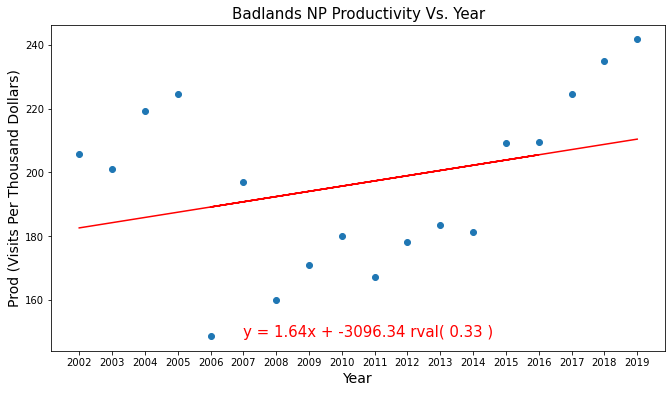

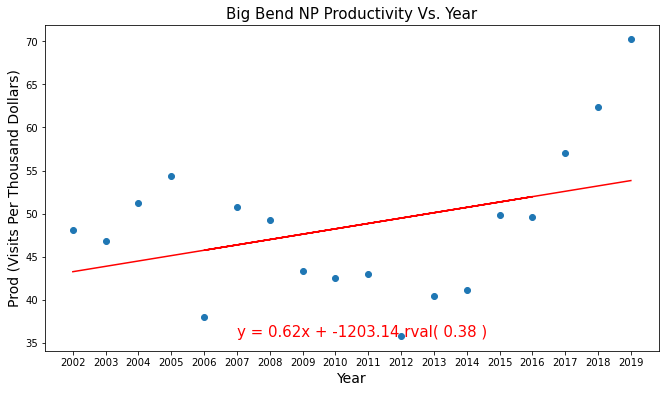

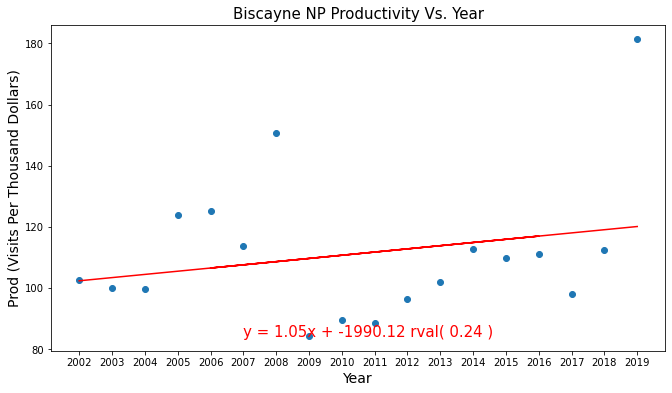

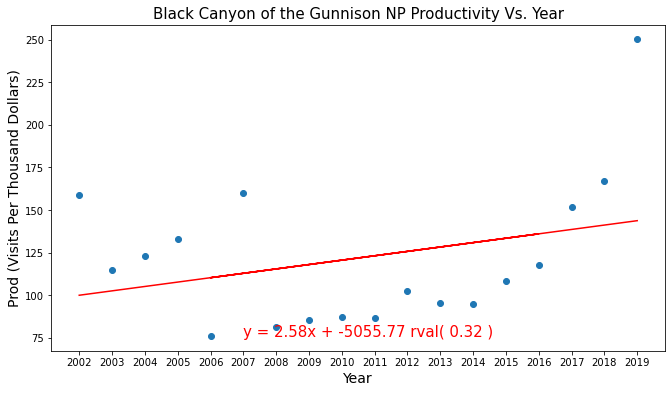

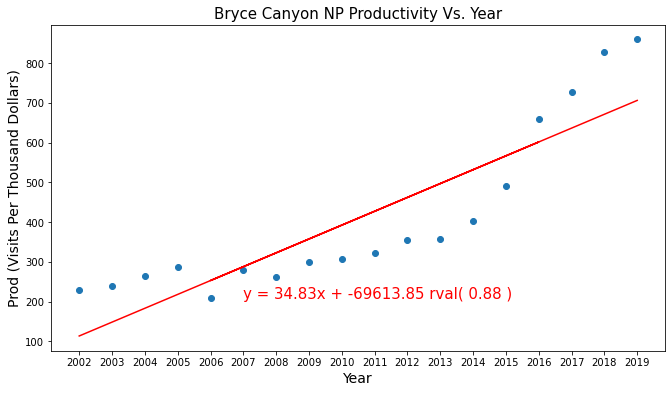

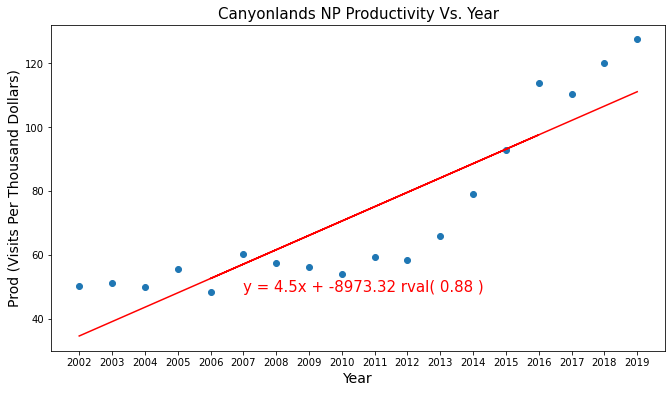

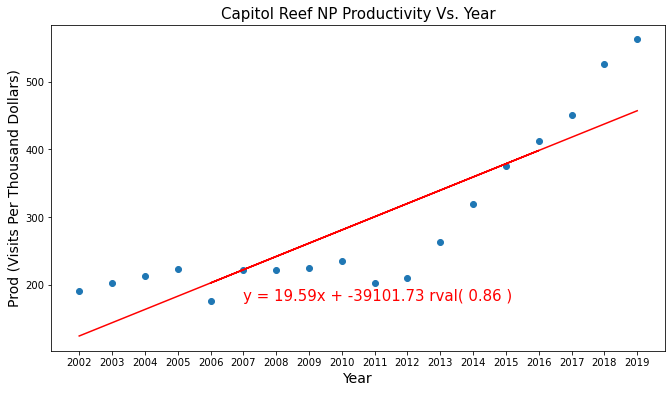

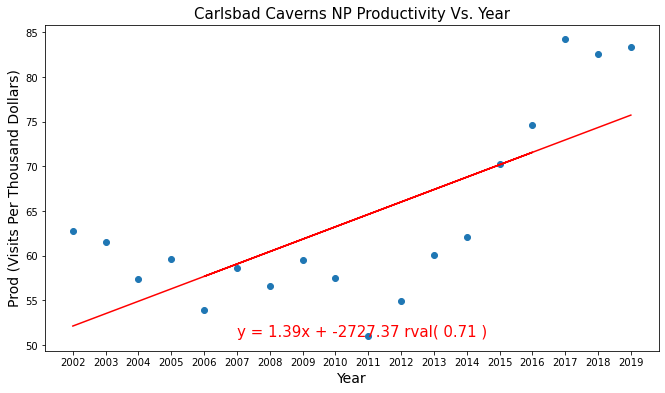

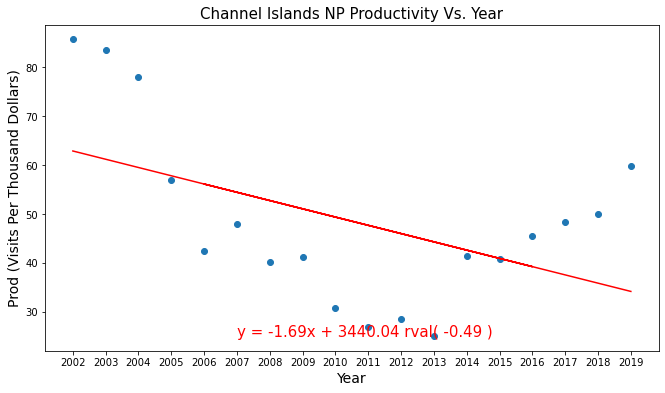

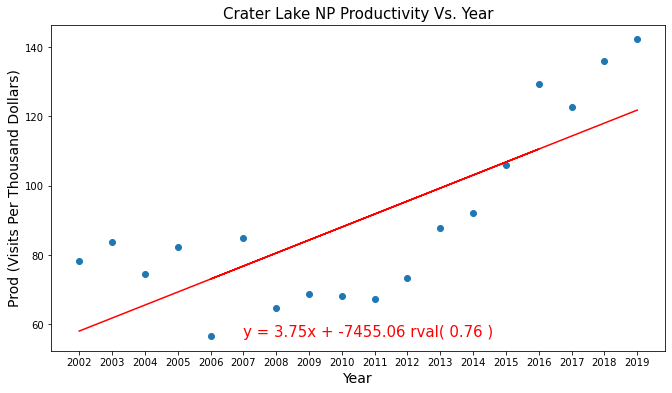

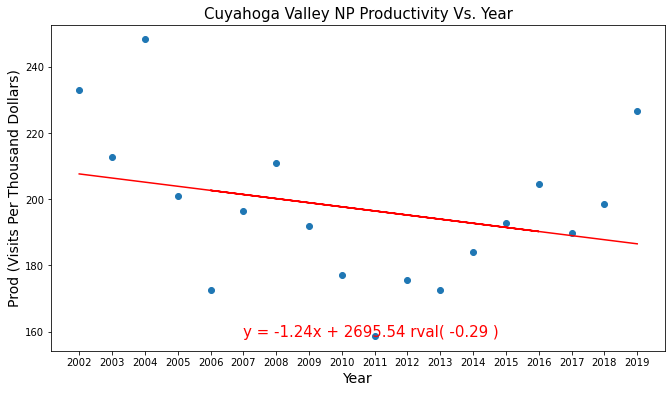

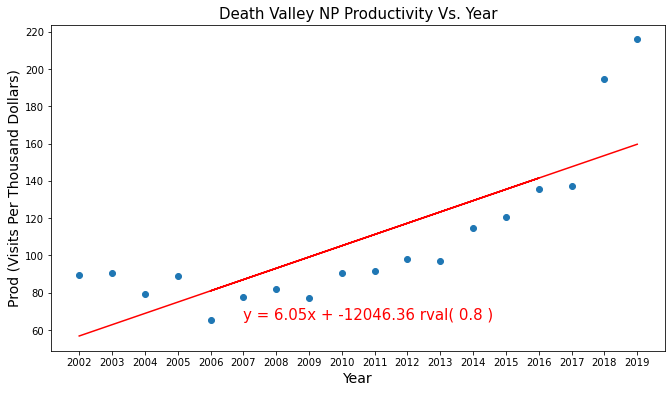

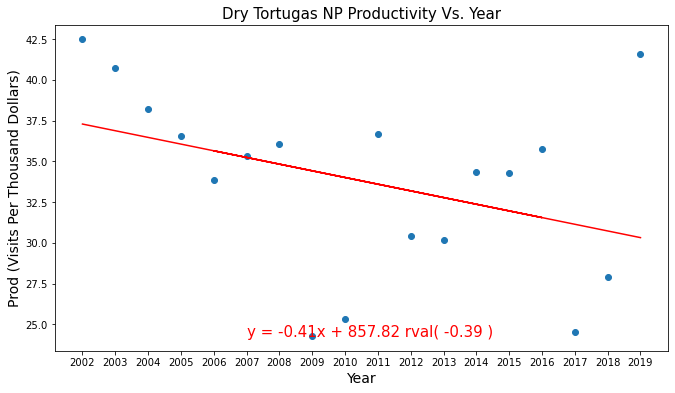

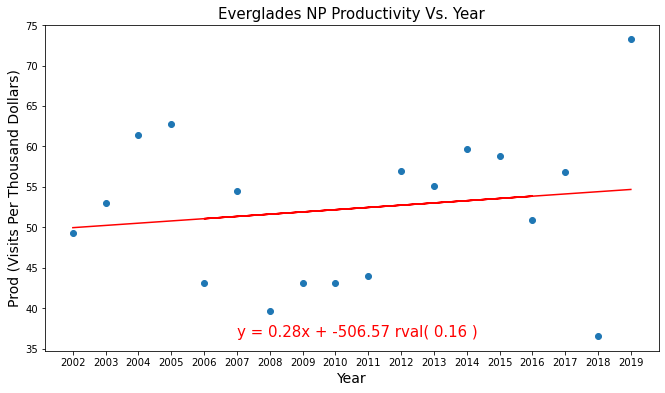

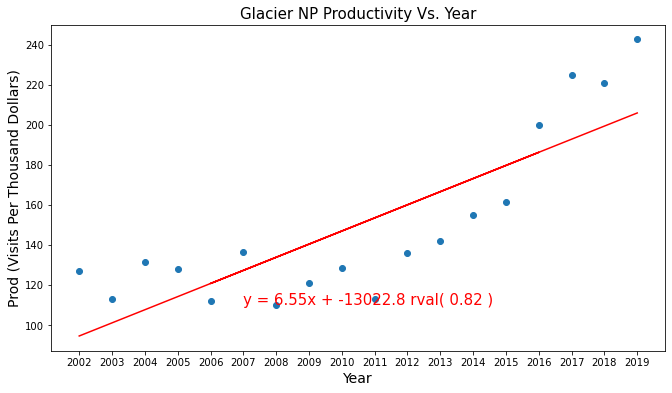

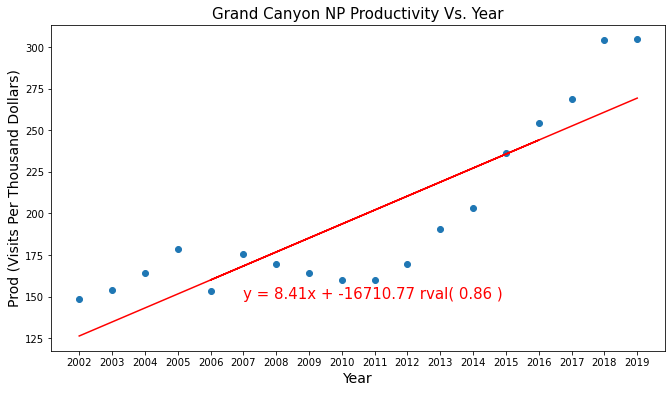

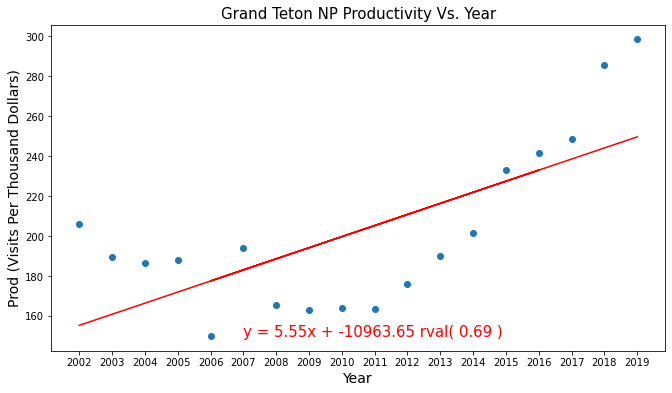

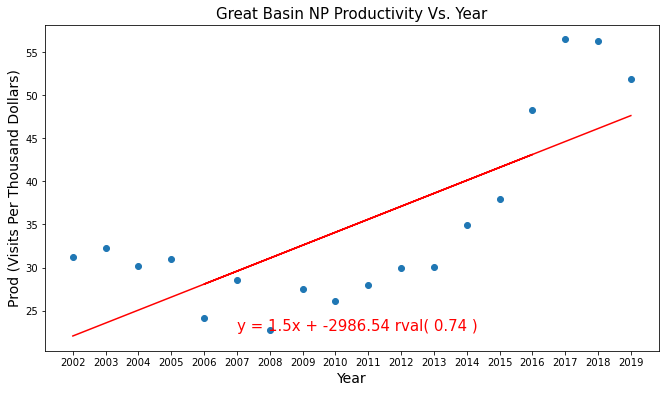

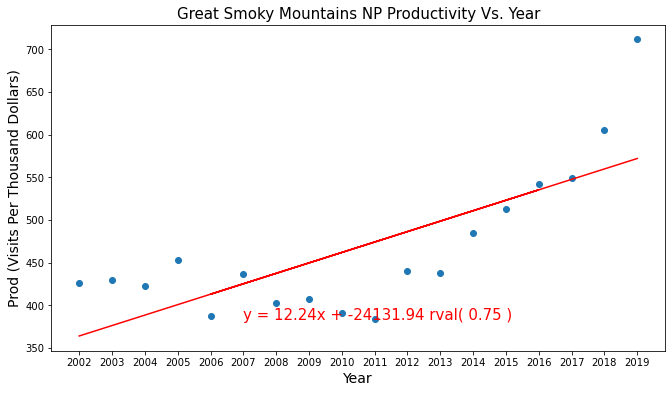

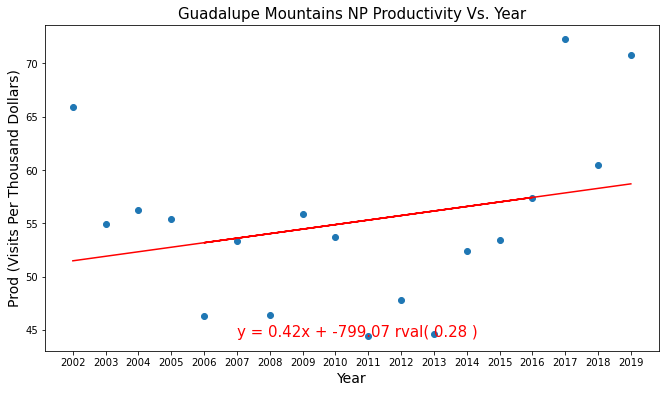

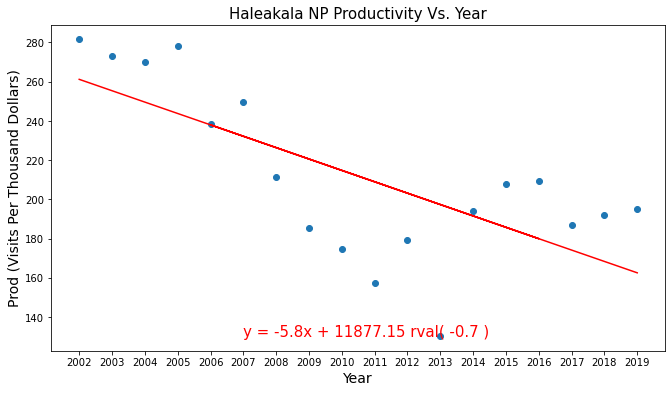

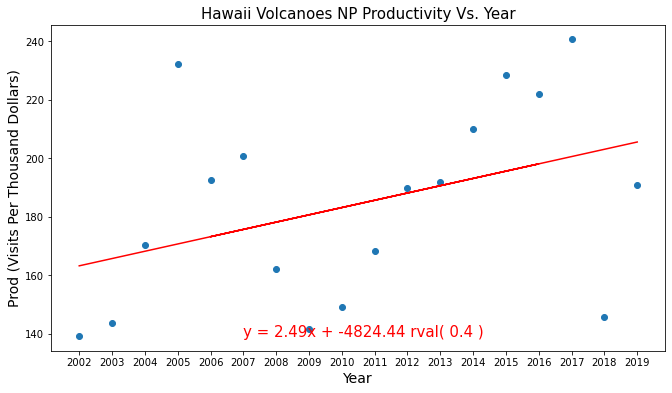

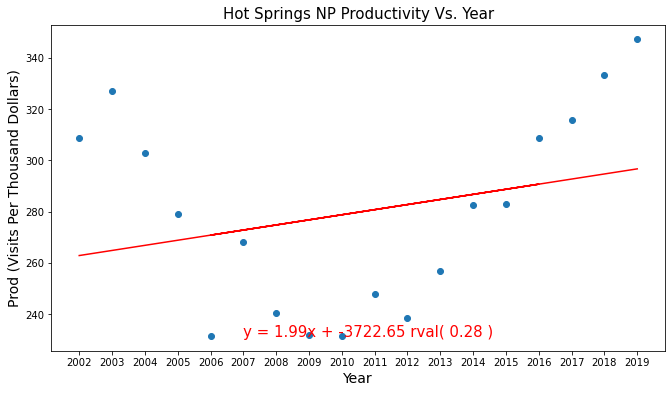

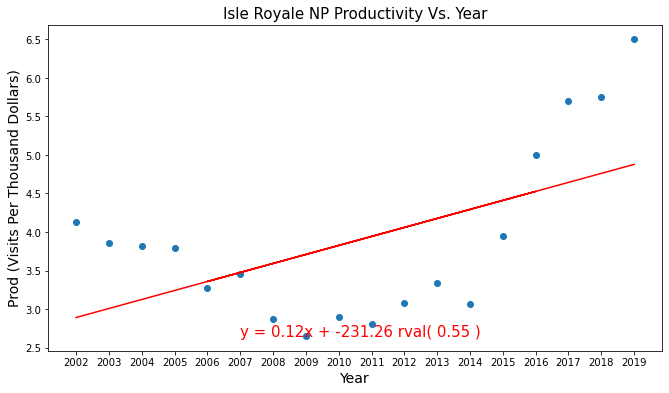

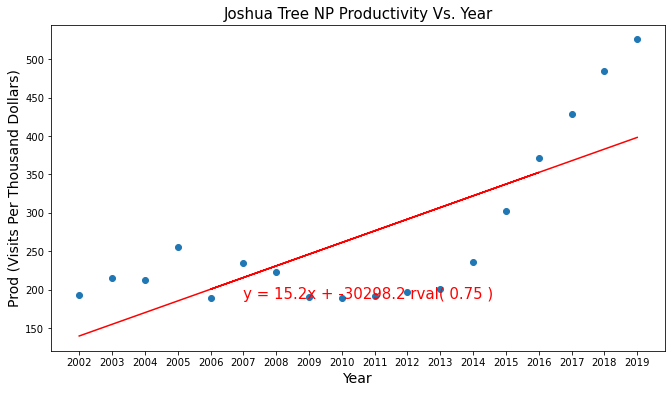

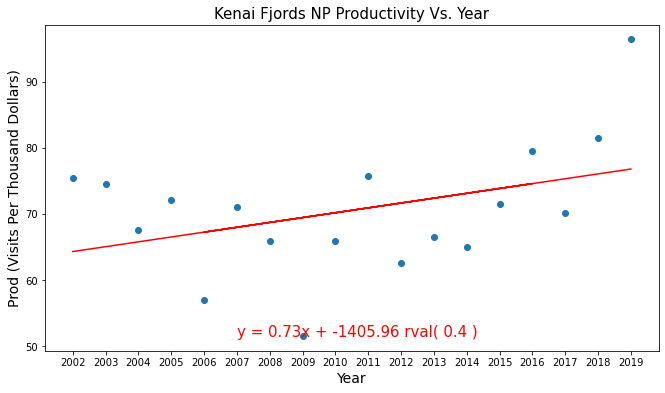

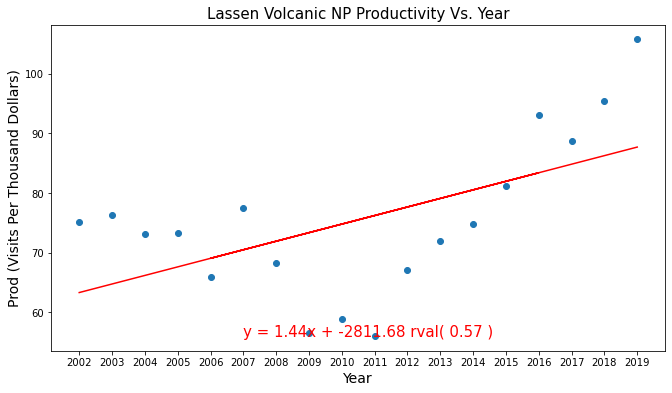

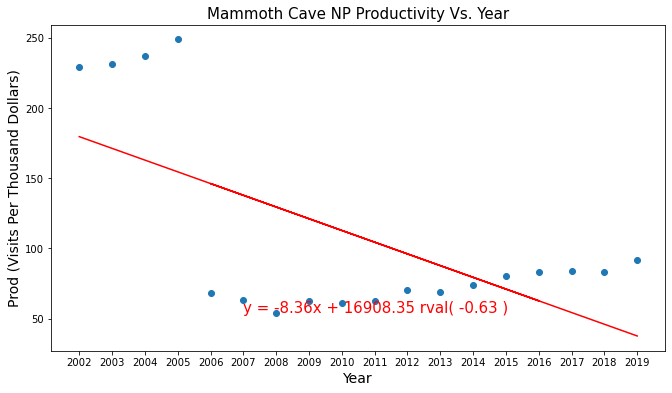

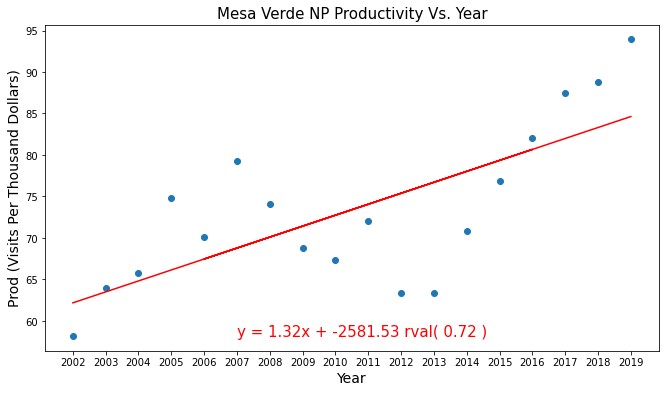

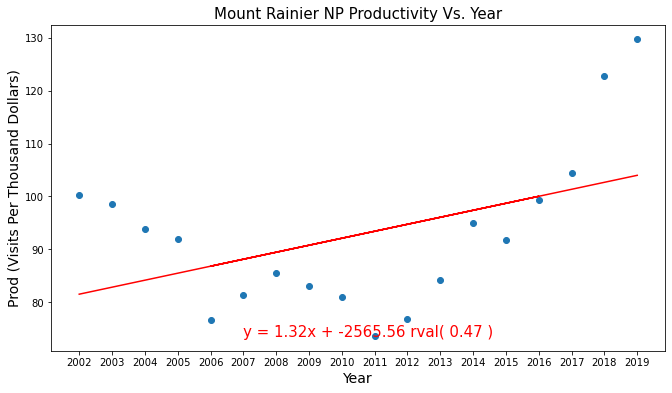

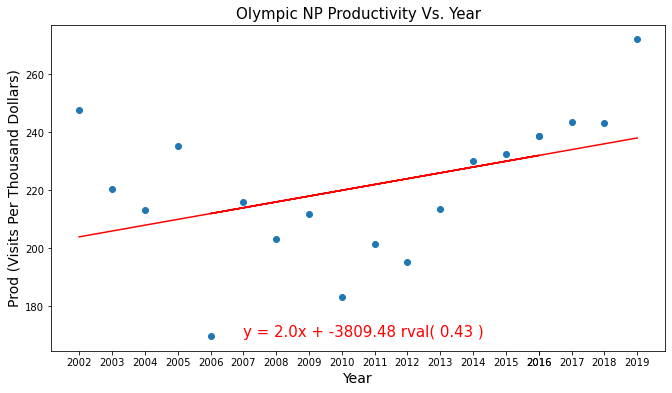

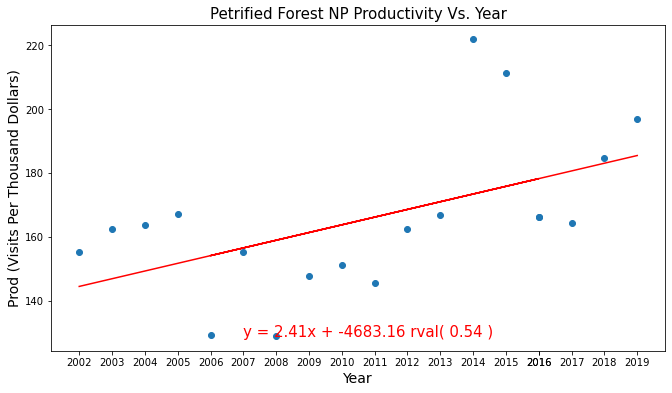

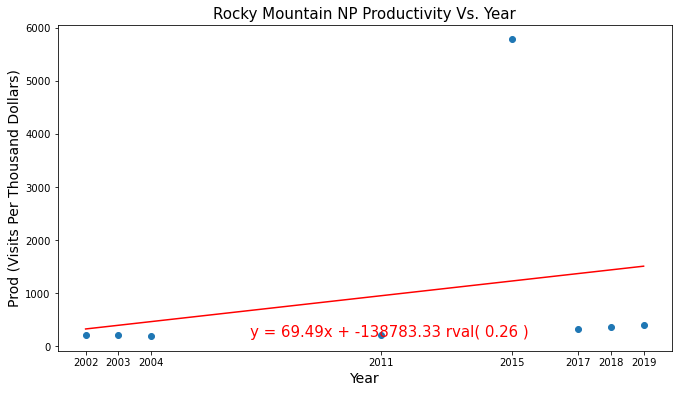

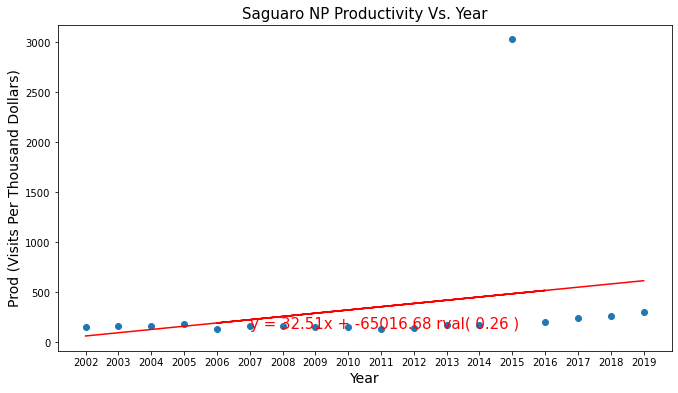

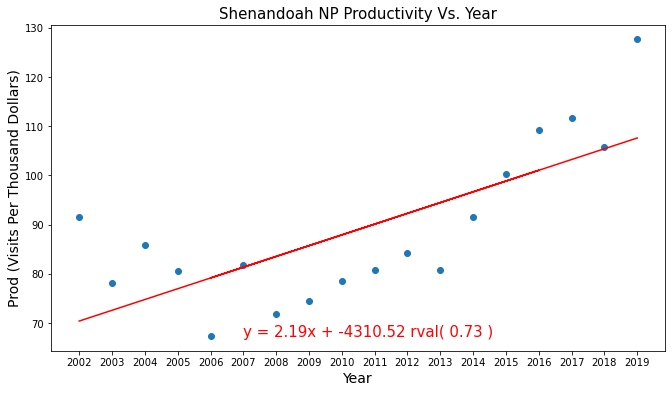

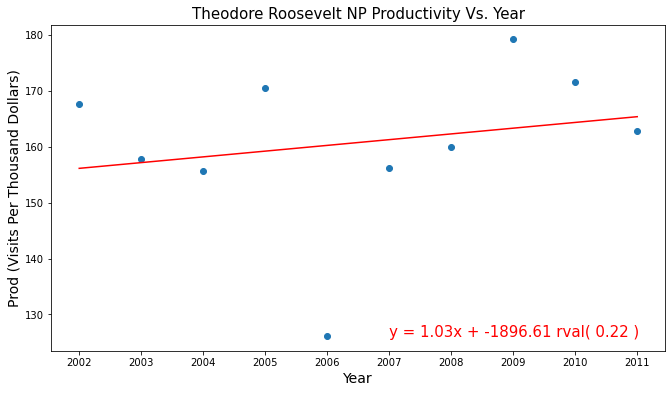

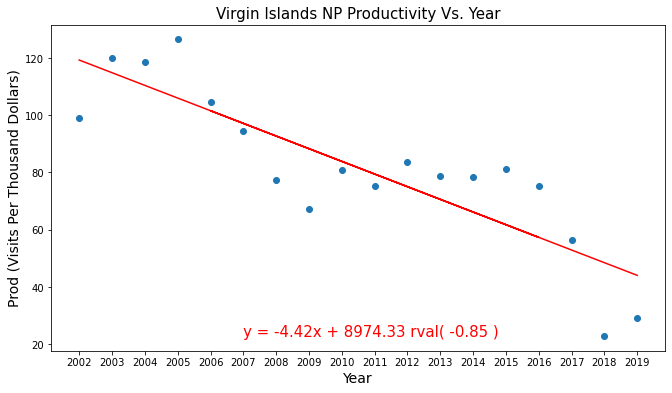

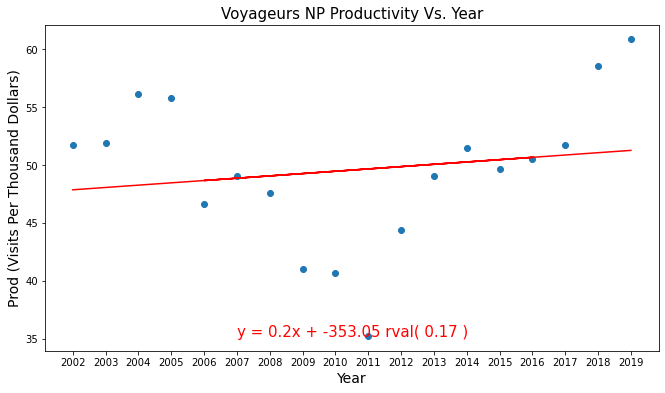

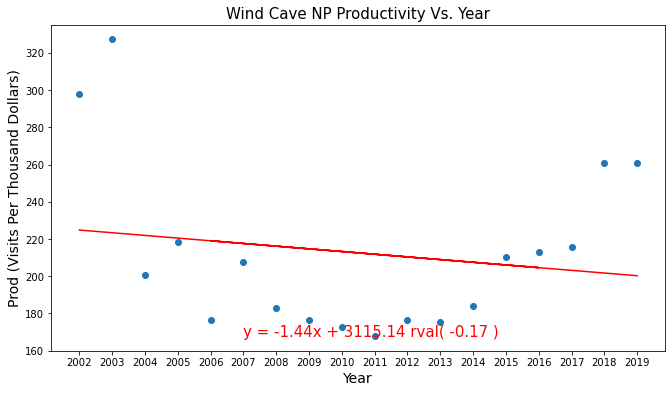

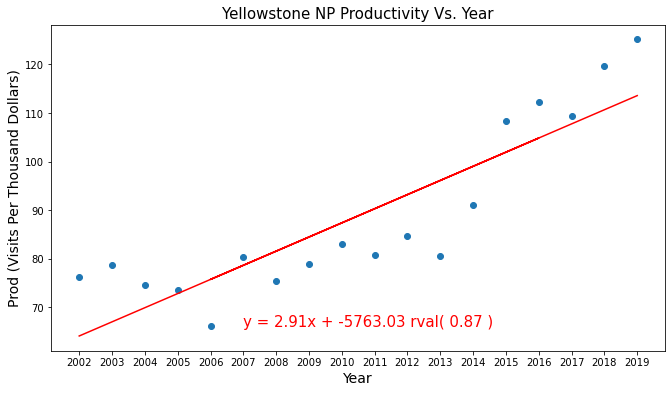

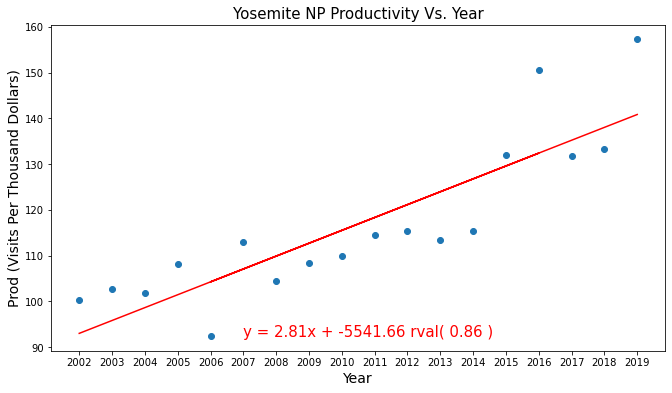

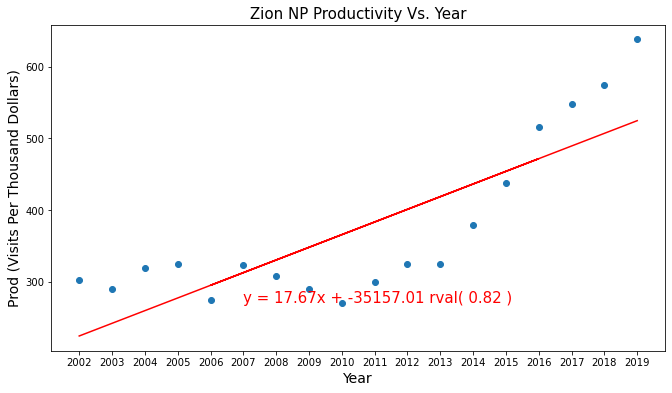

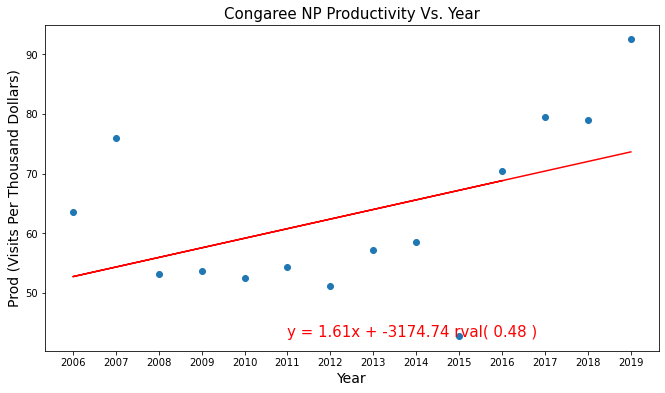

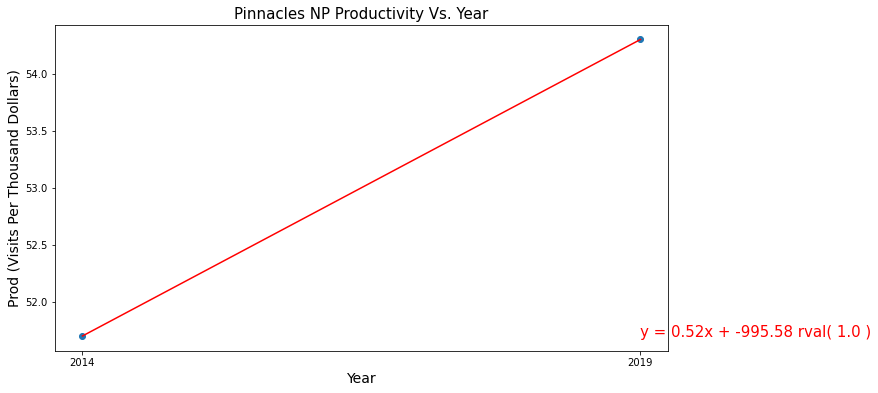

In [39]:
#Generate scatter/line charts for all national parks save rvalues and slopes into DataFrame Productivity_det_regression_df
parks = Productivity_det_df["Park Name"].unique()
slopes = []
rvals = []
park_names = []
line1 = plt

for park in parks:
    fig = plt 
    fig.figure(figsize=(11,6))
    line1 = plt
    x_vals = Productivity_det_df[Productivity_det_df["Park Name"] == park]["Year"]
    y_vals = Productivity_det_df[Productivity_det_df["Park Name"] == park]["Prod (Visits Per Thousand Dollars)"]
    ylim_top = Productivity_det_df[Productivity_det_df["Park Name"] == park]["Prod (Visits Per Thousand Dollars)"].max() + 10
    ylim_bottom = Productivity_det_df[Productivity_det_df["Park Name"] == park]["Prod (Visits Per Thousand Dollars)"].min() - 5
    xmin = Productivity_det_df[Productivity_det_df["Park Name"] == park]["Year"].min()
    park_names.append(park)
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_vals, y_vals)
    slopes.append(slope)
    rvals.append(rvalue)
    regress_values = x_vals * slope + intercept
    line_formula = f'y = {str(round(slope,2))}x + {str(round(intercept,2))} rval( {round(rvalue,2)} )'
    line1.annotate(line_formula,xy=(xmin + 5,ylim_bottom + 5),fontsize=15,color="red")
    fig.scatter(x=x_vals, y=y_vals, marker='o')
    fig.ylabel("Prod (Visits Per Thousand Dollars)",fontsize=14)
    fig.xlabel("Year",fontsize=14)
    fig.xticks(x_vals)
    fig.title(f"{park} Productivity Vs. Year",fontsize=15)
    fig.plot()
    line1.plot(x_vals,regress_values,"r-")
#     plt.savefig(output_graphs + f"productivity_{park}.png")
    


Productivity_det_regression_df = pd.DataFrame({"Park Name":park_names,
                                               "rvals":rvals,
                                               "slopes":slopes})

In [40]:
Productivity_det_regression_df

,Park Name,rvals,slopes
0,Acadia NP,0.598102,8.518751
1,Arches NP,0.779777,23.203509
2,Badlands NP,0.326400,1.637812
3,Big Bend NP,0.383855,0.622570
4,Biscayne NP,0.237916,1.045170
5,Black Canyon of the Gunnison NP,0.317285,2.575304
6,Bryce Canyon NP,0.878571,34.828978
7,Canyonlands NP,0.881238,4.499432
8,Capitol Reef NP,0.858926,19.593271
9,Carlsbad Caverns NP,0.707693,1.388369


In [41]:
#Added MAR 2/8
visits_per_capita_df =  pd.merge(budget_attendance_final_df, us_census_df, how="inner", on=["Year"])
visits_per_capita_det_df = visits_per_capita_df 
visits_per_capita_det_df["Visits Per Capita"] = round(visits_per_capita_det_df["Visits"] / visits_per_capita_det_df["Population"],5)

visits_per_capita_df
visits_per_capita_df.dtypes
#Build Productivity for all parks 
visits_per_capita_groupby = visits_per_capita_df.groupby(by=["Year","Population"])

visits_per_capita_summ_df  = visits_per_capita_groupby["Visits","AdjBudg(dollars in thousands)"].sum().reset_index()
visits_per_capita_summ_df["Visits Per Capita"] = round(visits_per_capita_summ_df["Visits"] / visits_per_capita_summ_df["Population"],5)


<ipython-input-41-fff04ac22bb7>:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  visits_per_capita_summ_df  = visits_per_capita_groupby["Visits","AdjBudg(dollars in thousands)"].sum().reset_index()


In [42]:
visits_per_capita_summ_df[["Year","Visits","Population"]]

,Year,Visits,Population
0,2002,61782862,287279318
1,2003,60655185,289815562
2,2004,60546764,292354658
3,2005,57477722,294993511
4,2006,54486019,297758969
5,2007,56064813,300608429
6,2008,55259586,303486012
7,2009,56868614,306307567
8,2010,58361419,309011475
9,2011,59371720,311584047


No handles with labels found to put in legend.


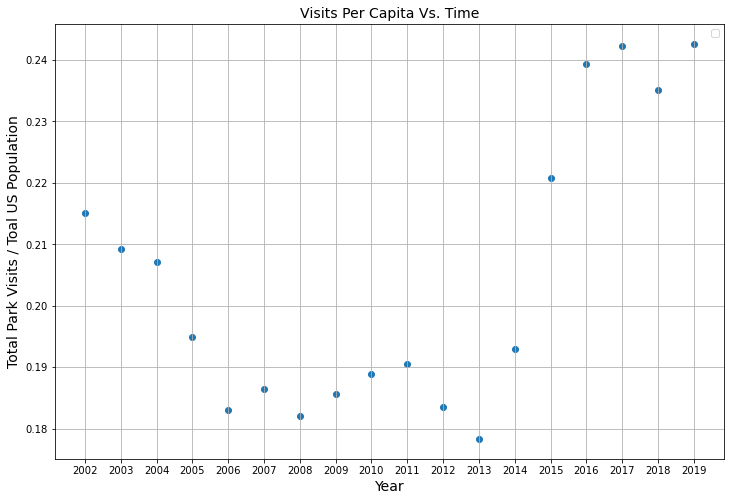

In [43]:
x_vals = visits_per_capita_summ_df["Year"].astype("str")
y_vals = visits_per_capita_summ_df["Visits Per Capita"]
fig1 = plt
fig1.figure(figsize=(12,8))
fig1.scatter(x_vals, y_vals)
fig1.grid()
fig1.title("Visits Per Capita Vs. Time",fontsize=14)
fig1.xlabel("Year",fontsize=14)
fig1.ylabel("Total Park Visits / Toal US Population", fontsize=14)
fig1.legend()
fig1.show()

In [44]:
attendance_master_detail.head()

,Park Name,Year,Visits,parkCode,fullName,lat,lon,State,Activity Count,Budget Request(dollars in thousands),AdjBudg(dollars in thousands)
0,Acadia NP,2019,3437286,acad,Acadia National Park,44.409286,-68.247501,ME,46,7312,7402.21
1,Acadia NP,2002,2558572,acad,Acadia National Park,44.409286,-68.247501,ME,46,4706,6770.98
2,Acadia NP,2003,2431062,acad,Acadia National Park,44.409286,-68.247501,ME,46,5686,7999.56
3,Acadia NP,2004,2207847,acad,Acadia National Park,44.409286,-68.247501,ME,46,6415,8789.16
4,Acadia NP,2005,2051484,acad,Acadia National Park,44.409286,-68.247501,ME,46,6277,8318.26


In [45]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the visits for each NP
visits_max = attendance_master_detail.groupby(["Park Name"]).agg({'Visits': ['min','max','mean','median','std','sem']})
visits_max

Visits                                     \
                                     min       max          mean     median   
Park Name                                                                     
Acadia NP                        2051484   3537575  2.586944e+06  2431057.0   
Arches NP                         733131   1663557  1.111179e+06  1027581.5   
Badlands NP                       840118   1054325  9.246558e+05   909022.0   
Big Bend NP                       292055    463832  3.643314e+05   363208.5   
Biscayne NP                       437745    708522  5.219472e+05   501888.5   
Black Canyon of the Gunnison NP   160185    432818  2.111803e+05   178579.0   
Bryce Canyon NP                   886436   2679478  1.479417e+06  1290746.0   
Canyonlands NP                    367078    776218  5.108917e+05   444833.5   
Capitol Reef NP                   511511   1227627  7.508197e+05   663165.5   
Carlsbad Caverns NP               365000    520026  4.287112e+05   424061.5   
Channel Islands NP                212029    613935  3.756614e+05   362806.5   
Congaree NP                        87513    159595  1.260927e+05   120774.0   
Crater Lake NP                    388972    756344  5.225485e+05   462789.0   
Cuyahoga Valley NP               2096053   3306175  2.490327e+06  2446103.0   
Death Valley NP                   704122   1740945  1.035391e+06   949419.5   
Dry Tortugas NP                    52011     79582  6.514839e+04    64034.5   
Everglades NP                     597124   1233837  1.003815e+06  1029602.5   
Glacier NP                       1664046   3305512  2.266323e+06  2122682.0   
Grand Canyon NP                  4001974   6380495  4.825019e+06  4417510.0   
Grand Teton NP                   2355693   3491151  2.773848e+06  2641001.5   
Great Basin NP                     69235    168028  1.018887e+05    90160.5   
Great Smoky Mountains NP         9008830  12547743  9.954732e+06  9417895.5   
Guadalupe Mountains NP            145670    225257  1.774069e+05   173252.0   
Haleakala NP                      785300   1521080  1.203042e+06  1163554.0   
Hawaii Volcanoes NP              1110998   2016702  1.468051e+06  1418077.5   
Hot Springs NP                   1238147   1561616  1.395327e+06  1407258.0   
Isle Royale NP                     14038     28196  1.871706e+04    17173.0   
Joshua Tree NP                   1178376   2988547  1.713832e+06  1394281.5   
Kenai Fjords NP                   218358    356601  2.849861e+05   282390.5   
Lassen Volcanic NP                351269    536068  4.220167e+05   399720.5   
Mammoth Cave NP                   446174   1891307  8.274339e+05   542398.0   
Mesa Verde NP                     406385    613788  5.242920e+05   548851.0   
Mount Rainier NP                 1038229   1518491  1.231258e+06  1204752.0   
Olympic NP                       2749197   3691310  3.157398e+06  3142774.0   
Petrified Forest NP               543714    836799  6.356805e+05   631613.0   
Pinnacles NP                      177224    196635  1.869295e+05   186929.5   
Rocky Mountain NP                2781899   4670053  3.733531e+06  3666428.5   
Saguaro NP                        610045   1020226  7.283492e+05   675916.5   
Shenandoah NP                    1075878   1458874  1.236840e+06  1231793.0   
Theodore Roosevelt NP             435359    623748  5.112467e+05   491746.5   
Virgin Islands NP                 112287    821681  4.961071e+05   455724.0   
Voyageurs NP                      177184    253891  2.311770e+05   234404.0   
Wind Cave NP                      516142    874167  6.152976e+05   598517.5   
Yellowstone NP                   2835651   4257177  3.437271e+06  3344756.5   
Yosemite NP                      3242644   5028868  3.803831e+06  3795438.0   
Zion NP                          2458792   4504812  3.149155e+06  2771394.5   

                                                              
                                          std            sem  
Park Name                           

In [46]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the budgets for each NP
visits_max = attendance_master_detail.groupby(["Park Name"]).agg({'AdjBudg(dollars in thousands)': ['min','max','mean','median','std','sem']})
visits_max

AdjBudg(dollars in thousands)            \
                                                          min       max   
Park Name                                                                 
Acadia NP                                             6770.98  10034.07   
Arches NP                                             1467.57   2351.25   
Badlands NP                                           4017.96   5651.22   
Big Bend NP                                           6605.50   8767.64   
Biscayne NP                                           3907.62   5376.67   
Black Canyon of the Gunnison NP                       1094.93   2109.26   
Bryce Canyon NP                                       3020.81   4269.87   
Canyonlands NP                                        5761.21   8112.24   
Capitol Reef NP                                       2180.57   3306.78   
Carlsbad Caverns NP                                   5284.40   7585.34   
Channel Islands NP                                    6857.57   9013.67   
Congaree NP                                           1520.35   2306.15   
Crater Lake NP                                        4953.36   6869.53   
Cuyahoga Valley NP                                    9873.32  14315.48   
Death Valley NP                                       8067.31  11333.25   
Dry Tortugas NP                                       1690.95   2214.13   
Everglades NP                                        15274.14  22150.42   
Glacier NP                                           12572.21  17537.78   
Grand Canyon NP                                      19615.04  27863.26   
Grand Teton NP                                       11410.05  16299.72   
Great Basin NP                                        2509.92   3399.29   
Great Smoky Mountains NP                             17636.93  24208.04   
Guadalupe Mountains NP                                2668.52   3765.34   
Haleakala NP                                          5093.07   6330.93   
Hawaii Volcanoes NP                                   7150.76   8758.15   
Hot Springs NP                                        4225.49   5663.89   
Isle Royale NP                                        4064.53   5679.28   
Joshua Tree NP                                        5384.28   7581.93   
Kenai Fjords NP                                       3269.61   4578.17   
Lassen Volcanic NP                                    4888.57   6533.89   
Mammoth Cave NP                                       6003.16   8791.36   
Mesa Verde NP                                         5922.17   8309.50   
Mount Rainier NP                                     11578.10  14706.90   
Olympic NP                                           11931.40  16188.53   
Petrified Forest NP                                   3268.84   4503.52   
Pinnacles NP                                          3263.77   3803.41   
Rocky Mountain NP                                      719.60  15368.34   
Saguaro NP                                             248.96   4668.08   
Shenandoah NP                                        11169.11  15975.69   
Theodore Roosevelt NP                                 2814.29   3636.67   
Virgin Islands NP                                     4599.05   6998.31   
Voyageurs NP                                          3828.66   6237.17   
Wind Cave NP                                          2358.74   3344.26   
Yellowstone NP                                       32129.55  43865.51   
Yosemite NP                                          28123.73  35489.54   
Zion NP                                               7034.73   9859.59   

                                                                       \
                                         mean     median          std   
Park Name                                                               
Acadia NP                         8594.685556   8712.725   760.493861   
Arches NP                         1966.641667   2092.400   298.0